In [297]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [298]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [299]:
ALPHABET_SIZE = 27
all_chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(all_chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [300]:
# let's prepare the data
BLOCK_SIZE = 3
def build(words):
    X = []
    Y = []
    for word in words:
        context = [0] * BLOCK_SIZE
        for letter in word + '.':
            letter_index = stoi[letter]
            X.append(context[:])
            Y.append(letter_index)
            context = context[1:] + [letter_index]
    return torch.tensor(X), torch.tensor(Y)


In [301]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_train, Y_train = build(words[:n1])
X_valid, Y_valid = build(words[n1:n2])
X_test, Y_test = build(words[n2:])


In [302]:
X_train.dtype, Y_train.dtype

(torch.int64, torch.int64)

In [303]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBEDDING_SIZE = 10
C = torch.randn((ALPHABET_SIZE, EMBEDDING_SIZE), generator=g, requires_grad=True)

In [304]:
HIDDEN_LAYER_OUTPUTS = 200
W1 = torch.randn((EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_OUTPUTS), generator=g, requires_grad=True)
b1 = torch.randn((HIDDEN_LAYER_OUTPUTS), generator=g, requires_grad=True)

In [305]:
W2 = torch.randn((HIDDEN_LAYER_OUTPUTS, ALPHABET_SIZE), generator=g, requires_grad=True)
b2 = torch.randn((ALPHABET_SIZE), generator=g, requires_grad=True)

In [306]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [307]:
BATCH_SIZE = 64

def step(X, Y, sc):

    batch_indices = torch.randint(0, X.shape[0], (BATCH_SIZE,))
    batchX = X[batch_indices]
    batchY = Y[batch_indices]
    # forward pass
    
    embeddings = C[batchX]
    hidden_outputs = (embeddings.view(-1, EMBEDDING_SIZE * BLOCK_SIZE) @ W1 + b1).tanh()
    outputs = hidden_outputs @ W2 + b2
    loss = F.cross_entropy(outputs, batchY)

    # backward pass
    for param in parameters:
        param.grad = None
    
    loss.backward()

    # update params
    LEARNING_RATE = 0.1 if sc < 100_000 else 0.01
    for param in parameters:
        param.data += -LEARNING_RATE * param.grad
    return loss.item()

In [308]:
steps = []
losses = []

Step 10000: loss 2.350511312484741
Step 20000: loss 2.587509870529175
Step 30000: loss 2.153770923614502
Step 40000: loss 2.097691774368286
Step 50000: loss 2.133617639541626
Step 60000: loss 2.2354753017425537
Step 70000: loss 2.5024335384368896
Step 80000: loss 2.084158182144165
Step 90000: loss 2.1504836082458496
Step 100000: loss 2.250014305114746
Step 110000: loss 2.4556729793548584
Step 120000: loss 1.9877341985702515
Step 130000: loss 2.0738635063171387
Step 140000: loss 2.223524570465088
Step 150000: loss 1.9074287414550781
Step 160000: loss 1.9966199398040771
Step 170000: loss 2.2242093086242676
Step 180000: loss 2.0010135173797607
Step 190000: loss 2.222118854522705
Step 200000: loss 1.979178786277771
Step 210000: loss 2.2274885177612305
Step 220000: loss 2.3746726512908936
Step 230000: loss 1.894091010093689
Step 240000: loss 2.2333567142486572
Step 250000: loss 2.1746695041656494
Step 260000: loss 1.8424348831176758
Step 270000: loss 2.158682346343994
Step 280000: loss 1.90

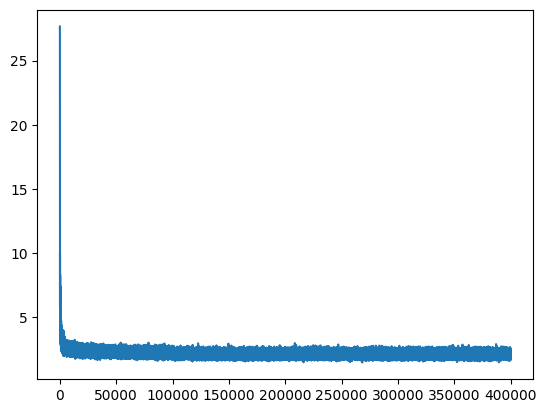

In [309]:
for _ in range(400_000):
    step_num = len(steps) + 1
    steps.append(step_num)
    loss = step(X_train, Y_train, step_num)
    losses.append(loss)
    if step_num % 10000 == 0:
        print(f"Step {step_num}: loss {loss}")

plt.plot(steps, losses)

In [310]:
def calculate_loss(X, Y):
    with torch.no_grad():
        embeddings = C[X]
        hidden_outputs = (embeddings.view(-1, EMBEDDING_SIZE * BLOCK_SIZE) @ W1 + b1).tanh()
        outputs = hidden_outputs @ W2 + b2
        loss = F.cross_entropy(outputs, Y)
        print(loss)

In [311]:
calculate_loss(X_train, Y_train)

tensor(2.1039)


In [312]:
calculate_loss(X_valid, Y_valid)

tensor(2.1449)


In [313]:
calculate_loss(X_test, Y_test)

tensor(2.1418)
